In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data_sets/mod3p1.csv', encoding='latin-1')

In [3]:
print (len(df))
print (df['Zip_Code'].nunique())

32526
14803


In [4]:
df.sort_values('Zip_Code',ascending=True).head(3)

,id,State_Code,State_Name,State_ab,County,City,Place,Type,Primary,Zip_Code,Area_Code,ALand,AWater,Lat,Lon,Mean,Median,Stdev,sum_w
32481,72026,72,Puerto Rico,PR,Adjuntas Municipio,Adjuntas,Adjuntas,Track,Track,601,787,42529236,210360,18.155582,-66.701046,24000,15004,29483,1243.880991
32519,7202946,72,Puerto Rico,PR,Adjuntas Municipio,Adjuntas,Adjuntas,Track,Track,601,787,44833906,90659,18.204166,-66.737830,19807,9378,21654,524.345149
32520,7202956,72,Puerto Rico,PR,Adjuntas Municipio,Adjuntas,Adjuntas,Track,Track,601,787,42529236,210360,18.155582,-66.701046,23682,15051,30309,615.289902


In [5]:
df = df.drop_duplicates(subset='Zip_Code', keep='first')
len(df)

14803

In [6]:
df = df.drop(['id','State_ab','Primary','Area_Code','Lat','Lon','County','State_Code','Place','sum_w','City'],axis = 1)

In [7]:
df.head(3)

,State_Name,Type,Zip_Code,ALand,AWater,Mean,Median,Stdev
0,Alabama,City,36611,10894952,909156,38773,30506,33101
1,Alabama,City,36048,26070325,23254,37725,19528,43789
2,Alabama,City,35051,44835274,261034,54606,31930,57348


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14803 entries, 0 to 32483
Data columns (total 8 columns):
State_Name    14803 non-null object
Type          14803 non-null object
Zip_Code      14803 non-null int64
ALand         14803 non-null int64
AWater        14803 non-null int64
Mean          14803 non-null int64
Median        14803 non-null int64
Stdev         14803 non-null int64
dtypes: int64(6), object(2)
memory usage: 1.0+ MB


In [9]:
df1 = pd.read_csv('data_sets/pop-by-zip-code.csv')

In [10]:
df1.head(2)

,zip_code,y-2016
0,601,17800
1,602,39716


In [11]:
print (len(df1))
print (df1['zip_code'].nunique())

33120
33120


In [12]:
df1['y-2016'].sum()

322072436

In [13]:
df1 = df1.rename(index=str, columns={"zip_code": "Zip_Code",'y-2016':'Population'})
df1.head(2)

,Zip_Code,Population
0,601,17800
1,602,39716


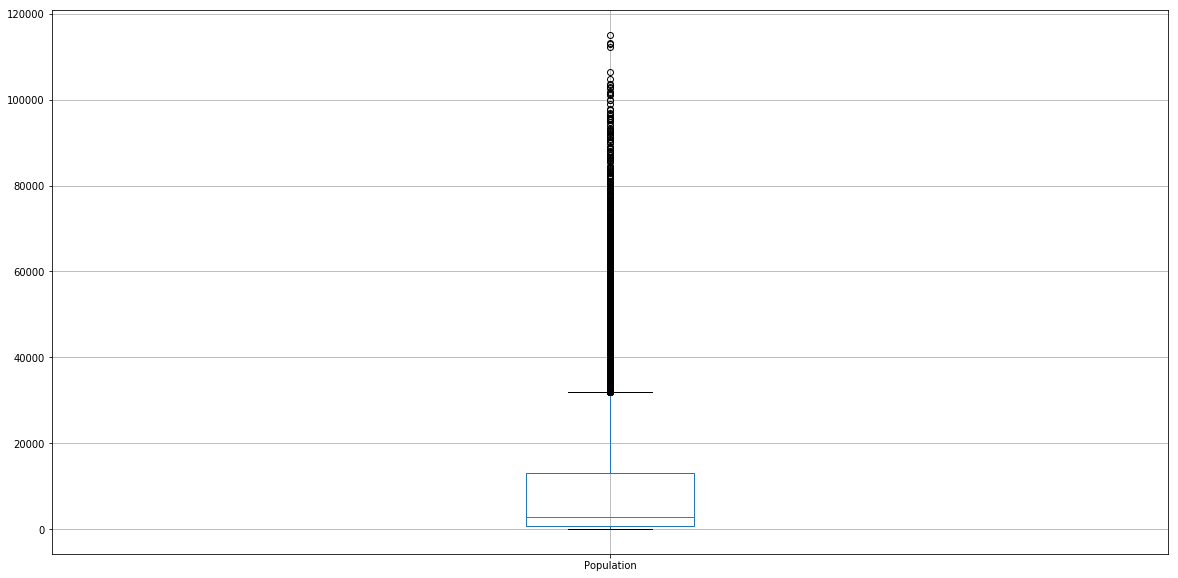

In [14]:
plt.figure(figsize=(20, 10))
df1.boxplot(column=['Population'])
plt.show();

In [15]:
df1[df1['Population']<2000].count()


Zip_Code      14465
Population    14465
dtype: int64

In [16]:
df1 = df1[df1['Population']>2000]

In [17]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18652 entries, 0 to 33119
Data columns (total 2 columns):
Zip_Code      18652 non-null int64
Population    18652 non-null int64
dtypes: int64(2)
memory usage: 437.2+ KB


In [18]:
df3 = pd.merge(df, df1, on='Zip_Code', how='inner')

In [19]:
len(df3)

12815

In [20]:
df3.isnull().sum()

State_Name    0
Type          0
Zip_Code      0
ALand         0
AWater        0
Mean          0
Median        0
Stdev         0
Population    0
dtype: int64

In [21]:
df4=pd.read_excel('data_sets/tableAll.xlsx')
df4.head(3)

,"Number of beneficiaries with benefits in current-payment status and total monthly benefits, December 2017",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,State or area,ZIP Code,Number,NaN,NaN,NaN,NaN,NaN,Total monthly benefits\n(thousands of dollars),NaN,NaN,Number of OASDI beneficiaries aged 65 or older
1,NaN,NaN,Total,Retired workers,Disabled workers,Widow(er)s and parents,Spouses,Children,All beneficiaries,Retired workers,Widow(er)s and parents,NaN
2,Alabama,35004,2235,1410,385,160,70,210,2992,2070,218,1510


In [22]:
df4 = df4.drop('Unnamed: 2',axis = 1)

In [23]:
df4.at[1, 'Number of beneficiaries with benefits in current-payment status and total monthly benefits, December 2017'] = 'State or area'
df4.at[1, 'Unnamed: 1'] = 'Zip_Code'
df4.at[1, 'Unnamed: 11'] ='Number of OASDI beneficiaries aged 65 or older'
df4.at[1,'Unnamed: 3'] = 'Retired_workers_number'
df4.at[1,'Unnamed: 5'] = 'Widow(er)s_and_parents_number'

In [24]:
df4.head(2)

,"Number of beneficiaries with benefits in current-payment status and total monthly benefits, December 2017",Unnamed: 1,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,State or area,ZIP Code,NaN,NaN,NaN,NaN,NaN,Total monthly benefits\n(thousands of dollars),NaN,NaN,Number of OASDI beneficiaries aged 65 or older
1,State or area,Zip_Code,Retired_workers_number,Disabled workers,Widow(er)s_and_parents_number,Spouses,Children,All beneficiaries,Retired workers,Widow(er)s and parents,Number of OASDI beneficiaries aged 65 or older


In [25]:
df4.columns = df4.iloc[1].values
df4.head(2)

,State or area,Zip_Code,Retired_workers_number,Disabled workers,Widow(er)s_and_parents_number,Spouses,Children,All beneficiaries,Retired workers,Widow(er)s and parents,Number of OASDI beneficiaries aged 65 or older
0,State or area,ZIP Code,NaN,NaN,NaN,NaN,NaN,Total monthly benefits\n(thousands of dollars),NaN,NaN,Number of OASDI beneficiaries aged 65 or older
1,State or area,Zip_Code,Retired_workers_number,Disabled workers,Widow(er)s_and_parents_number,Spouses,Children,All beneficiaries,Retired workers,Widow(er)s and parents,Number of OASDI beneficiaries aged 65 or older


In [26]:
df4 = df4.drop([0, 1])
df4.head(2)

,State or area,Zip_Code,Retired_workers_number,Disabled workers,Widow(er)s_and_parents_number,Spouses,Children,All beneficiaries,Retired workers,Widow(er)s and parents,Number of OASDI beneficiaries aged 65 or older
2,Alabama,35004,1410,385,160,70,210,2992,2070,218,1510
3,Alabama,35005,1085,425,155,80,205,2423,1520,193,1200


In [27]:
df4['All beneficiaries'] = df4['All beneficiaries']*1000
df4['Retired workers'] = df4['Retired workers']*1000
df4['Widow(er)s and parents'] = df4['Widow(er)s and parents']*1000
df4.head(2)

,State or area,Zip_Code,Retired_workers_number,Disabled workers,Widow(er)s_and_parents_number,Spouses,Children,All beneficiaries,Retired workers,Widow(er)s and parents,Number of OASDI beneficiaries aged 65 or older
2,Alabama,35004,1410,385,160,70,210,2992000,2070000,218000,1510
3,Alabama,35005,1085,425,155,80,205,2423000,1520000,193000,1200


In [28]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37327 entries, 2 to 37328
Data columns (total 11 columns):
State or area                                     37324 non-null object
Zip_Code                                          37320 non-null object
Retired_workers_number                            37320 non-null object
Disabled workers                                  37320 non-null object
Widow(er)s_and_parents_number                     37320 non-null object
Spouses                                           37320 non-null object
Children                                          37320 non-null object
All beneficiaries                                 37320 non-null object
Retired workers                                   37320 non-null object
Widow(er)s and parents                            37320 non-null object
Number of OASDI beneficiaries aged 65 or older    37320 non-null object
dtypes: object(11)
memory usage: 3.4+ MB


In [29]:
df4 = df4.drop('State or area',axis =1)
df4.head(2)

,Zip_Code,Retired_workers_number,Disabled workers,Widow(er)s_and_parents_number,Spouses,Children,All beneficiaries,Retired workers,Widow(er)s and parents,Number of OASDI beneficiaries aged 65 or older
2,35004,1410,385,160,70,210,2992000,2070000,218000,1510
3,35005,1085,425,155,80,205,2423000,1520000,193000,1200


In [30]:
df4.isnull().sum()

Zip_Code                                          7
Retired_workers_number                            7
Disabled workers                                  7
Widow(er)s_and_parents_number                     7
Spouses                                           7
Children                                          7
All beneficiaries                                 7
Retired workers                                   7
Widow(er)s and parents                            7
Number of OASDI beneficiaries aged 65 or older    7
dtype: int64

In [31]:
df4.dropna(axis='rows',inplace=True)
df4.isnull().sum()

Zip_Code                                          0
Retired_workers_number                            0
Disabled workers                                  0
Widow(er)s_and_parents_number                     0
Spouses                                           0
Children                                          0
All beneficiaries                                 0
Retired workers                                   0
Widow(er)s and parents                            0
Number of OASDI beneficiaries aged 65 or older    0
dtype: int64

In [32]:
for col in df4.columns:
    df4[col] = df4[col].astype(int)
    

In [33]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37320 entries, 2 to 37321
Data columns (total 10 columns):
Zip_Code                                          37320 non-null int32
Retired_workers_number                            37320 non-null int32
Disabled workers                                  37320 non-null int32
Widow(er)s_and_parents_number                     37320 non-null int32
Spouses                                           37320 non-null int32
Children                                          37320 non-null int32
All beneficiaries                                 37320 non-null int32
Retired workers                                   37320 non-null int32
Widow(er)s and parents                            37320 non-null int32
Number of OASDI beneficiaries aged 65 or older    37320 non-null int32
dtypes: int32(10)
memory usage: 1.7 MB


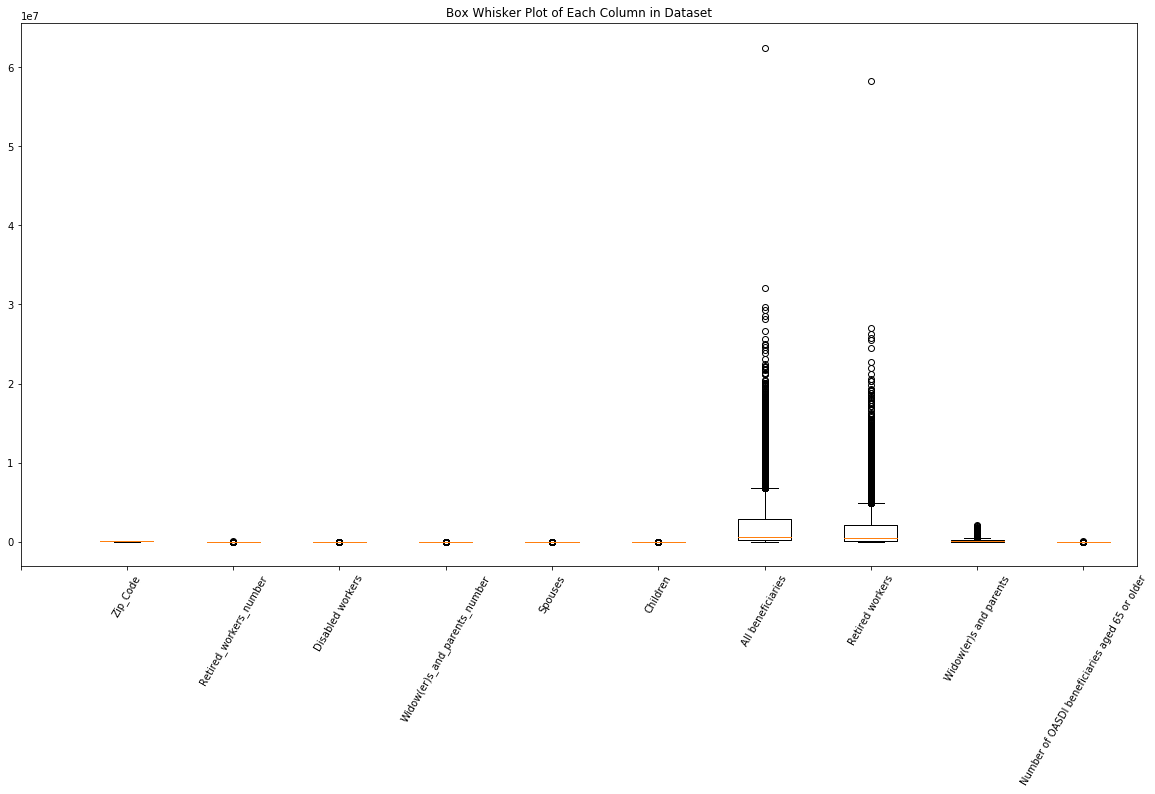

In [34]:
# Create a Box Whisker Plot of each column
plt.figure(figsize=(20, 10))
plt.boxplot([df4[col] for col in df4.columns])
plt.title("Box Whisker Plot of Each Column in Dataset")
plt.xticks(range(len(df4.columns.values)+1), ['']+list(df4.columns.values), rotation=60)
plt.show()

In [35]:
for col in df4.columns:
    df4 = df4[df4[str(col)] > 0]
    
len(df4)

30351

In [36]:
df5 = pd.merge(df3, df4, on='Zip_Code', how='inner')
df5.head(3)

,State_Name,Type,Zip_Code,ALand,AWater,Mean,Median,Stdev,Population,Retired_workers_number,Disabled workers,Widow(er)s_and_parents_number,Spouses,Children,All beneficiaries,Retired workers,Widow(er)s and parents,Number of OASDI beneficiaries aged 65 or older
0,Alabama,City,36611,10894952,909156,38773,30506,33101,5955,735,325,130,40,125,1585000,977000,161000,835
1,Alabama,City,35051,44835274,261034,54606,31930,57348,8753,1220,390,155,60,165,2583000,1755000,201000,1310
2,Alabama,City,36572,36878729,2374530,63919,52814,47707,6276,1065,250,135,75,155,2298000,1602000,189000,1180


In [37]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12796 entries, 0 to 12795
Data columns (total 18 columns):
State_Name                                        12796 non-null object
Type                                              12796 non-null object
Zip_Code                                          12796 non-null int64
ALand                                             12796 non-null int64
AWater                                            12796 non-null int64
Mean                                              12796 non-null int64
Median                                            12796 non-null int64
Stdev                                             12796 non-null int64
Population                                        12796 non-null int64
Retired_workers_number                            12796 non-null int32
Disabled workers                                  12796 non-null int32
Widow(er)s_and_parents_number                     12796 non-null int32
Spouses                              

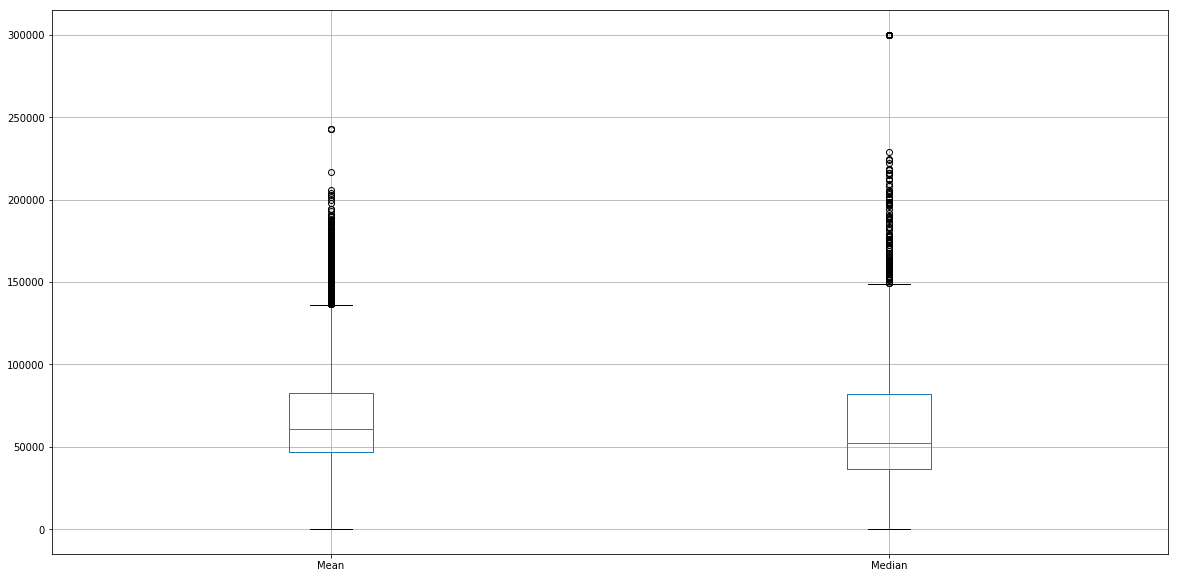

In [38]:
plt.figure(figsize=(20, 10))
boxplot = df5.boxplot(column=['Mean', 'Median'])
plt.show();

In [ ]:
len(df5)

In [39]:
df5 = df5[df5.Median != 300000]
df5 = df5[df5.Median>1000]

In [40]:
len(df5)

10956

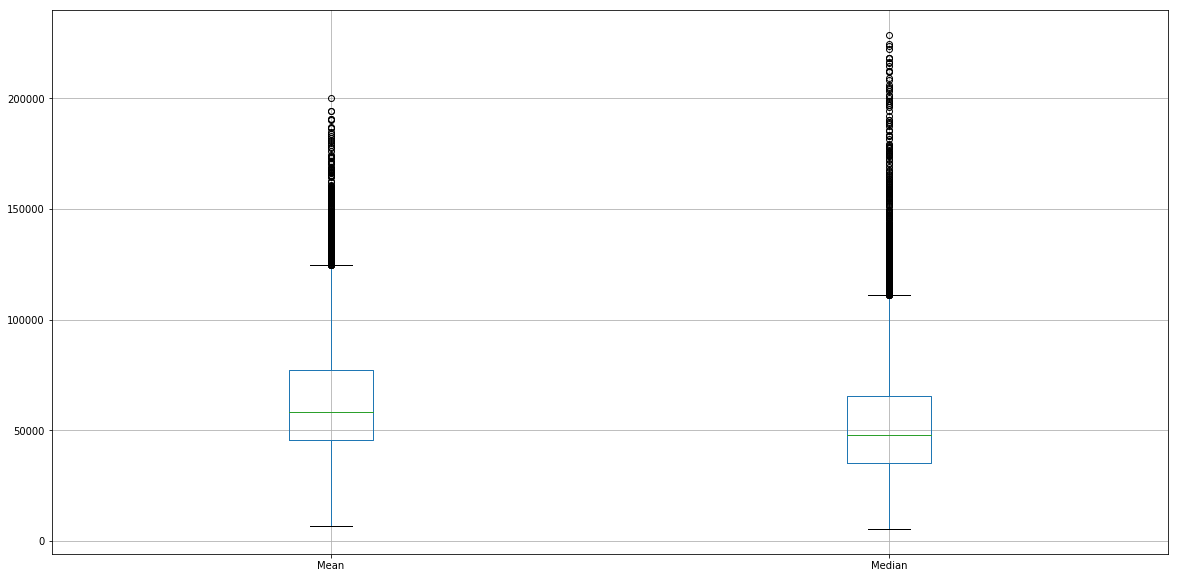

In [41]:
plt.figure(figsize=(20, 10))
boxplot = df5.boxplot(column=['Mean', 'Median'])
plt.show();

In [42]:
df5.head(3)

,State_Name,Type,Zip_Code,ALand,AWater,Mean,Median,Stdev,Population,Retired_workers_number,Disabled workers,Widow(er)s_and_parents_number,Spouses,Children,All beneficiaries,Retired workers,Widow(er)s and parents,Number of OASDI beneficiaries aged 65 or older
0,Alabama,City,36611,10894952,909156,38773,30506,33101,5955,735,325,130,40,125,1585000,977000,161000,835
1,Alabama,City,35051,44835274,261034,54606,31930,57348,8753,1220,390,155,60,165,2583000,1755000,201000,1310
2,Alabama,City,36572,36878729,2374530,63919,52814,47707,6276,1065,250,135,75,155,2298000,1602000,189000,1180


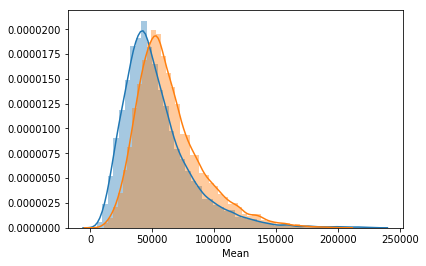

In [43]:

sns.distplot(df5['Median']);
sns.distplot(df5['Mean']);

In [44]:
df5.sort_values('Median').head()

,State_Name,Type,Zip_Code,ALand,AWater,Mean,Median,Stdev,Population,Retired_workers_number,Disabled workers,Widow(er)s_and_parents_number,Spouses,Children,All beneficiaries,Retired workers,Widow(er)s and parents,Number of OASDI beneficiaries aged 65 or older
12781,Puerto Rico,Track,921,228567,0,6804,5252,5600,36104,3990,815,715,445,440,5864000,3902000,658000,4685
8038,New York,Track,14206,1669444,0,19808,6524,29889,20352,2515,1135,340,110,430,5240000,3286000,419000,2715
1680,Colorado,Town,81125,2139228,0,10946,6808,8591,3367,335,110,35,20,35,545000,376000,33000,355
12041,Washington,CDP,98841,9775086,0,10964,6819,8597,8538,1565,395,160,60,145,2831000,2083000,197000,1685
3378,Illinois,Track,62204,2964356,0,15067,7280,21849,8295,605,345,95,25,170,1206000,689000,96000,670


In [46]:
df5['Type'].value_counts()


Track           9134
City             705
CDP              508
Town             265
Village          227
Borough           92
Community         14
Urban              8
County             2
Municipality       1
Name: Type, dtype: int64

In [47]:
df5['Type'] = df5['Type'].replace(['Municipality', 'County'], 'Community')
df5['Type'] = df5['Type'].replace(['Urban'], 'City')

In [48]:
df5['Type'].value_counts()

Track        9134
City          713
CDP           508
Town          265
Village       227
Borough        92
Community      17
Name: Type, dtype: int64

In [49]:
df5.describe()

,Zip_Code,ALand,AWater,Mean,Median,Stdev,Population,Retired_workers_number,Disabled workers,Widow(er)s_and_parents_number,Spouses,Children,All beneficiaries,Retired workers,Widow(er)s and parents,Number of OASDI beneficiaries aged 65 or older
count,10956.000000,1.095600e+04,1.095600e+04,10956.000000,10956.000000,10956.000000,10956.000000,10956.000000,10956.000000,10956.000000,10956.000000,10956.000000,1.095600e+04,1.095600e+04,1.095600e+04,10956.000000
mean,48590.331690,9.697742e+07,2.714306e+06,64099.360442,53749.294268,47171.827583,20953.999726,2611.073841,553.692497,250.804126,147.632804,262.285049,4.923120e+06,3.668255e+06,3.248473e+05,2810.998540
std,28116.963795,4.026962e+08,2.282352e+07,27009.278301,28072.723212,15284.234092,16896.604136,1990.423203,455.282008,187.381745,136.286936,214.204124,3.699188e+06,2.915059e+06,2.440520e+05,2141.273185
min,601.000000,6.909400e+04,0.000000e+00,6804.000000,5252.000000,5600.000000,2003.000000,25.000000,10.000000,5.000000,5.000000,5.000000,8.700000e+04,2.300000e+04,5.000000e+03,25.000000
25%,27536.750000,2.567361e+06,0.000000e+00,45455.500000,35095.750000,36399.750000,7078.250000,1013.750000,205.000000,100.000000,50.000000,100.000000,1.928000e+06,1.365750e+06,1.270000e+05,1090.000000
50%,46170.000000,8.086629e+06,7.177800e+04,58284.000000,47701.500000,45668.500000,16822.000000,2160.000000,430.000000,210.000000,105.000000,205.000000,4.102000e+06,2.935500e+06,2.690000e+05,2320.000000
75%,73116.250000,5.912435e+07,7.635110e+05,77111.000000,65459.500000,56682.000000,30276.000000,3726.250000,775.000000,355.000000,200.000000,370.000000,7.046250e+06,5.256250e+06,4.640000e+05,4010.000000
max,99835.000000,1.563472e+10,1.396368e+09,200012.000000,228723.000000,103836.000000,115104.000000,37440.000000,3490.000000,1895.000000,1645.000000,1825.000000,6.248100e+07,5.826300e+07,2.126000e+06,38455.000000


In [50]:
df5 = pd.get_dummies(df5, columns=['Type'])